In [1]:
# train a quantum-classical generative adversarial network on a gaussian probability distribution
import numpy as np
from numpy.random import rand
from numpy.random import randn
from keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, Dropout, Reshape, LeakyReLU, Flatten, BatchNormalization
from qibo import gates, hamiltonians, models
from matplotlib import pyplot
from scipy.optimize import minimize

In [2]:
# define the standalone discriminator model
def define_discriminator(n_inputs=1, alpha=0.2, dropout=0.2):
    model = Sequential()
        
    model.add(Dense(200, use_bias=False, input_dim=n_inputs))
    model.add(Reshape((50,2,2)))
    
    model.add(Conv2D(64, kernel_size=3, strides=1, padding='same', kernel_initializer='glorot_normal'))
    model.add(LeakyReLU(alpha=alpha))
    
    model.add(Conv2D(32, kernel_size=3, strides=1, padding='same', kernel_initializer='glorot_normal'))
    model.add(LeakyReLU(alpha=alpha))

    model.add(Conv2D(16, kernel_size=3, strides=1, padding='same', kernel_initializer='glorot_normal'))
    model.add(LeakyReLU(alpha=alpha))

    model.add(Conv2D(8, kernel_size=3, strides=1, padding='same', kernel_initializer='glorot_normal'))

    model.add(Flatten())
    model.add(LeakyReLU(alpha=alpha))
    model.add(Dropout(dropout)) 

    model.add(Dense(1, activation='sigmoid'))
    
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def rotate(theta, x, layers=4, nqubits=1):
    new_theta = []
    index = 0
    for l in range(layers):
        for q in range(nqubits):
           new_theta.append(theta[index]*x + theta[index+1])
           index += 2
        for q in range(nqubits):
           new_theta.append(theta[index]*x + theta[index+1])
           index += 2
    return new_theta
 
# define the combined generator and discriminator model, for updating the generator
def define_cost_gan(params, discriminator, latent_dim, samples):
    # generate fake samples
    x_fake, y_fake = generate_fake_samples(params, latent_dim, samples)
    # evaluate discriminator on fake examples
    _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
    return acc_fake
 
# generate real samples with class labels
def generate_real_samples(samples, sigma=0.20, mu=0.0):
    # generate samples from the distribution
    s = np.random.normal(mu, sigma, samples)
    # shape array
    X = s.reshape(samples, 1)
    # generate class labels
    y = np.ones((samples, 1))
    return X, y

# define hamiltonian to generate fake samples
def hamiltonian(nqubits=1):
    m0 = (1/nqubits)*hamiltonians.Z(nqubits, numpy=True).matrix
    ham = hamiltonians.Hamiltonian(nqubits, m0)
    return ham
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, samples):
    # generate points in the latent space
    x_input = randn(latent_dim * samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(samples, latent_dim)
    return x_input
 
# use the generator to generate fake examples, with class labels
def generate_fake_samples(params, latent_dim, samples, nqubits=1, layers=4):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, samples)
    # quantum generator circuit
    circuit = models.Circuit(nqubits)
    for l in range(layers):
        for q in range(nqubits):
            circuit.add(gates.RY(q, theta=0))
        for q in range(nqubits):
            circuit.add(gates.RZ(q, theta=0))    
    # generator outputs
    X = []
    for i in range(samples):
        newparams = rotate(params, x_input[i][0])
        circuit.set_parameters(newparams)
        X.append(hamiltonian().expectation(circuit.execute()).numpy().real)
    # shape array
    X = np.array(X).reshape(samples, 1)
    # create class labels
    y = np.zeros((samples, 1))
    return X, y
 
# evaluate the discriminator and plot real and fake distributions
def summarize_performance(epoch, params, discriminator, latent_dim, samples, nbins):
    # prepare real samples
    x_real, y_real = generate_real_samples(samples)
    # evaluate discriminator on real examples
    _, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(params, latent_dim, samples)
    # evaluate discriminator on fake examples
    _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('epoch: ',epoch, 'acc_real: ', acc_real, 'acc_fake: ', acc_fake)
    # histogram plot real and fake data points
    #pyplot.hist(x_real, np.linspace(-1.0, 1.0, nbins+1), color='red', label='real', alpha=0.5)
    #pyplot.hist(x_fake, np.linspace(-1.0, 1.0, nbins+1), color='blue', label='fake', alpha=0.5)
    pyplot.hist(x_real, color='red', label='real', alpha=0.5)
    pyplot.hist(x_fake, color='blue', label='fake', alpha=0.5)
    pyplot.legend()
    pyplot.show()
    
    # save generator parameters
    np.savetxt(str(epoch)+"_qGAN_quantum_classical_parameters", [params], newline='')
    print("Saved generator to disk")
    # serialize weights to HDF5
    discriminator.save_weights(str(epoch)+"_discriminator.h5")
    print("Saved discriminator to disk")
 
# train the generator and discriminator
def train(d_model, latent_dim, n_epochs=5000, samples=256, nbins=49, n_eval=100):
    # determine half the size of one batch, for updating the discriminator
    half_samples = int(samples / 2)
    initial_params = np.random.uniform(0, 2*np.pi, 16)
    # prepare real samples
    x_real, y_real = generate_real_samples(half_samples)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(initial_params, latent_dim, half_samples)
    # update discriminator
    d_model.train_on_batch(x_real, y_real)
    d_model.train_on_batch(x_fake, y_fake)
    # update generator
    train_generator = minimize(lambda p: define_cost_gan(p, d_model, latent_dim, samples), initial_params,
                          method='Nelder-Mead', options={'maxiter': 192, 'maxfev': 192})
    summarize_performance(1, train_generator.x, d_model, latent_dim, samples, nbins)    
    # manually enumerate epochs
    for i in range(n_epochs):
        # prepare real samples
        x_real, y_real = generate_real_samples(half_samples)
        # prepare fake examples
        x_fake, y_fake = generate_fake_samples(train_generator.x, latent_dim, half_samples)
        # update discriminator
        d_model.train_on_batch(x_real, y_real)
        d_model.train_on_batch(x_fake, y_fake)
        # update generator
        train_generator = minimize(lambda p: define_cost_gan(p, d_model, latent_dim, samples), train_generator.x,
                          method='Nelder-Mead', options={'maxiter': 192, 'maxfev': 192}) 
        # evaluate the model every n_eval epochs
        if (i+1) % n_eval == 0:
            summarize_performance(i+2, train_generator.x, d_model, latent_dim, samples, nbins)

epoch:  1 acc_real:  1.0 acc_fake:  0.0


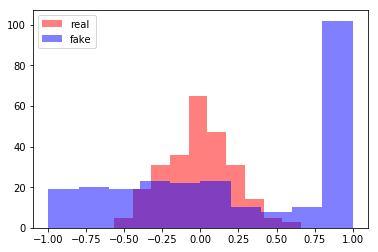

Saved discriminator to disk
Saved discriminator to disk
epoch:  11 acc_real:  0.59375 acc_fake:  0.59375


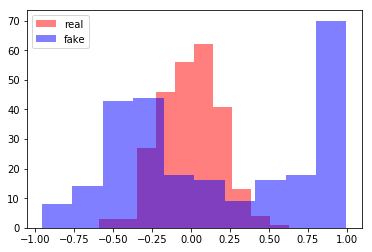

Saved discriminator to disk
Saved discriminator to disk
epoch:  21 acc_real:  0.5703125 acc_fake:  0.640625


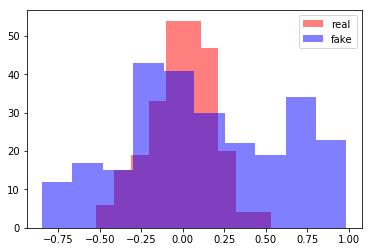

Saved discriminator to disk
Saved discriminator to disk
epoch:  31 acc_real:  0.87890625 acc_fake:  0.49609375


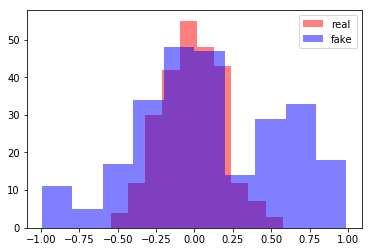

Saved discriminator to disk
Saved discriminator to disk
epoch:  41 acc_real:  0.94140625 acc_fake:  0.27734375


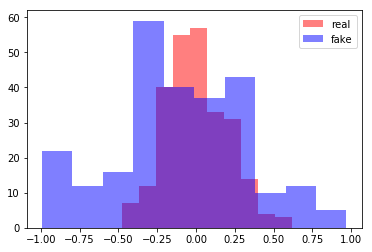

Saved discriminator to disk
Saved discriminator to disk
epoch:  51 acc_real:  0.96484375 acc_fake:  0.24609375


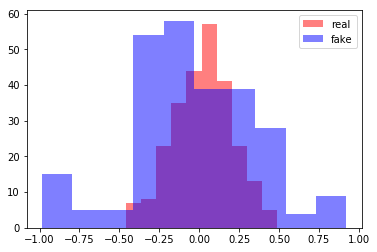

Saved discriminator to disk
Saved discriminator to disk
epoch:  61 acc_real:  0.765625 acc_fake:  0.32421875


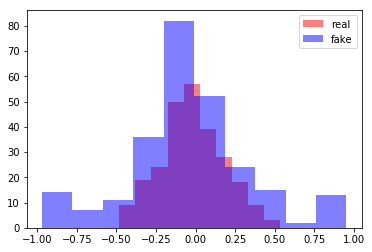

Saved discriminator to disk
Saved discriminator to disk


KeyboardInterrupt: 

In [3]:
# size of the latent space
latent_dim = 1
# create the discriminator
discriminator = define_discriminator()
# serialize generator and discriminator to JSON
disc_model_json = discriminator.to_json()
with open("discriminator.json", "w") as json_file:
    json_file.write(disc_model_json)
# train model
train(discriminator, latent_dim)

(array([ 108.,  445.,  386.,  251.,  242.,  207.,  440.,  313.,  633.,
         508.,  722., 2649., 2072., 2020., 1249., 1332., 1240., 1619.,
         697.,  486.,  919.,  204.,  118.,  145.,  210.,  158.,  211.,
         234.,  182.]),
 array([-1.        , -0.93103448, -0.86206897, -0.79310345, -0.72413793,
        -0.65517241, -0.5862069 , -0.51724138, -0.44827586, -0.37931034,
        -0.31034483, -0.24137931, -0.17241379, -0.10344828, -0.03448276,
         0.03448276,  0.10344828,  0.17241379,  0.24137931,  0.31034483,
         0.37931034,  0.44827586,  0.51724138,  0.5862069 ,  0.65517241,
         0.72413793,  0.79310345,  0.86206897,  0.93103448,  1.        ]),
 <a list of 29 Patch objects>)

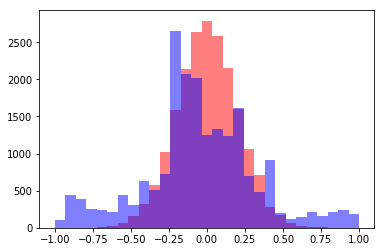

In [4]:
x_real, y_real = generate_real_samples(20000)
params = np.loadtxt("61_qGAN_quantum_classical_parameters")
x_fake, y_fake = generate_fake_samples(params, latent_dim, 20000)
pyplot.hist(x_real, np.linspace(-1.0, 1.0, 30), color='red', label='real', alpha=0.5)
pyplot.hist(x_fake, np.linspace(-1.0, 1.0, 30), color='blue', label='fake', alpha=0.5)